In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

from wind_dir_classifier import load_netcdf
from models import data_prep, compile_and_fit, evaluate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import TimeDistributed
from keras.layers import Flatten
import keras_tuner
from tensorflow import keras

In [2]:
# loading needed data
df = load_netcdf('C:/Studia/maciej-romanski/data/gaj_olawski')

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


In [4]:
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, 2014, 2020, 2021, 2021, 24, 1, y_featurename='windspeed_100')

In [32]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int("units", min_value=32, max_value=512, step=32), 
        activation=hp.Choice("activation", ["relu", "tanh"]), 
        # input_shape=(24, X_train.shape[2]
    ))
    
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )

    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))

    model.add(Dense(1))
    # model.add(Reshape([1,24]))
    # model.add(Dense(1))
    # model.add(Reshape([1]))
    # # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"]
    )
    return model

In [33]:
build_model(keras_tuner.HyperParameters())

In [37]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_mean_squared_error",
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory="tuner_results",
    project_name="dense_tuning",
)
tuner.search_space_summary()

Search space summary
Default search space size: 6
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [38]:
tuner.search(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

Trial 50 Complete [00h 00m 30s]
val_mean_squared_error: 0.001069806341547519

Best val_mean_squared_error So Far: 0.001069806341547519
Total elapsed time: 00h 26m 16s
INFO:tensorflow:Oracle triggered exit


In [40]:
tuner.results_summary()

Results summary
Results in tuner_results\dense_tuning
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 49 summary
Hyperparameters:
units: 96
activation: relu
num_layers: 2
units_0: 384
dropout: False
lr: 0.000690732191713988
units_1: 96
units_2: 512
units_3: 512
units_4: 32
Score: 0.001069806341547519

Trial 34 summary
Hyperparameters:
units: 320
activation: relu
num_layers: 2
units_0: 512
dropout: False
lr: 0.0013825682381639706
units_1: 128
units_2: 128
units_3: 352
units_4: 384
Score: 0.001082299742847681

Trial 13 summary
Hyperparameters:
units: 32
activation: relu
num_layers: 4
units_0: 128
dropout: False
lr: 0.0006859193583509903
units_1: 512
units_2: 64
units_3: 480
units_4: 480
Score: 0.0011122935102321208

Trial 06 summary
Hyperparameters:
units: 416
activation: relu
num_layers: 3
units_0: 320
dropout: True
lr: 0.00029819396759250306
units_1: 512
units_2: 64
units_3: 448
units_4: 192
Score: 0.001139841042459011

Trial 08 summary
Hyperpara

In [42]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 24, 15))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 360)               0         
                                                                 
 dense (Dense)               (None, 96)                34656     
                                                                 
 dense_1 (Dense)             (None, 384)               37248     
                                                                 
 dense_2 (Dense)             (None, 96)                36960     
                                                                 
 dense_3 (Dense)             (None, 1)                 97        
                                                                 
Total params: 108,961
Trainable params: 108,961
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters()
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2, mode='min')

model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
1917/1917 [==============================] - 7s 4ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 2/50
1917/1917 [==============================] - 7s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3/50
1917/1917 [==============================] - 6s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 4/50
1917/1917 [==============================] - 7s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 5/50
1917/1917 [==============================] - 6s 3ms/step - loss: 9.7751e-04 - mean_squared_error: 9.7751e-04
Epoch 6/50
1917/1917 [==============================] - 6s 3ms/step - loss: 9.3910e-04 - mean_squared_error: 9.3910e-04
Epoch 7/50
1917/1917 [==============================] - 6s 3ms/step - loss: 9.1236e-04 - mean_squared_error: 9.1236e-04
Epoch 8/50
1917/1917 [==============================] - 6s 3ms/step - loss: 8.7833e-04 - mean_squared_error: 8.7833e-04
Epoch 9/50
1917/1917 [==============================] - 6s 3ms/step - lo

273/273 [==============================] - 0s 2ms/step
Test Score: 0.6282 RMSE


(0.6282247784037778,
 array([[ 3.4571693],
        [ 3.9883678],
        [ 2.5264857],
        ...,
        [ 9.6182165],
        [ 9.788751 ],
        [10.145499 ]], dtype=float32),
 array([[ 3.60816267],
        [ 2.74873716],
        [ 2.14197716],
        ...,
        [ 9.70355844],
        [10.13628912],
        [11.05822973]]))

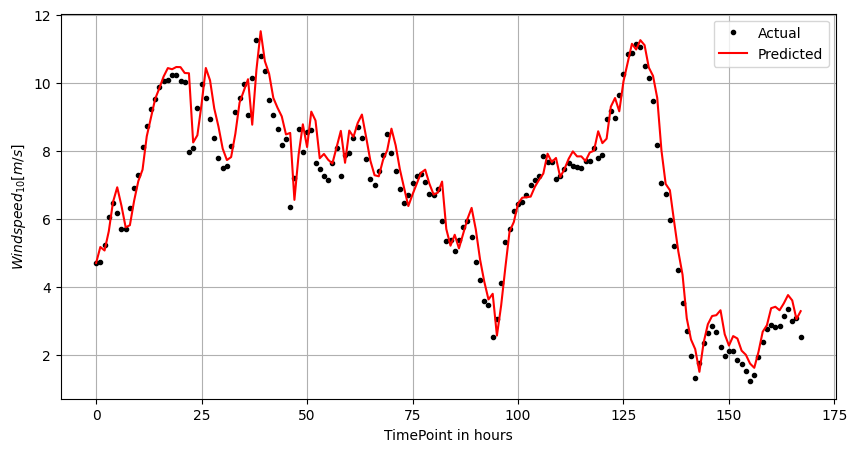

In [45]:
evaluate(model, X_test, y_test, scaler_y, save_to='figures/dense_tuned.jpg')